In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Đọc dataset
df = pd.read_csv("/Users/hoangvupham/Desktop/KLTN_VU/Data/final_cleaned_data.csv")

# Xem 5 dòng đầu
df.head()

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,...,Traffic_Weather,Vehicle_Area,Time_Band,Expected_Speed,Expected_Time_min,Residual_Ratio,Delay_Flag,Delay_Minutes,Loss_Value,Loss_Amount
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,...,0,1_3,Midday,2.211342,82.080902,1.461972,0,37.919098,1.154931e+05,5165.0
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,...,3,2_0,Evening,4.859696,249.194992,0.662132,0,0.000000,0.000000e+00,3087.0
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,...,4,1_3,Morning,4.133603,22.538561,5.767893,1,107.461439,2.383946e+06,226355.0
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,...,12,1_0,Evening,4.537247,103.019308,1.019226,0,1.980692,1.538114e+04,5190.0
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,...,0,2_0,Midday,2.269078,164.211340,0.913457,0,0.000000,0.000000e+00,8553.0


In [46]:
# ==========================================================
# 🔹 MÔ HÌNH 3 TẦNG: LOGIT + EXPONENTIAL + GAMMA
# ==========================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import expon
from sklearn.preprocessing import LabelEncoder, StandardScaler


# ==========================================================
# Biến mục tiêu
y = df["Delay_Flag"].astype(float)

# Biến đầu vào chọn lọc (bỏ Time_Band)
features = [
    "Agent_Age", "Agent_Rating",                # đặc trưng agent
    "Efficiency",                   # vận hành
    "Expected_Speed", "Expected_Time_min",      # kỳ vọng
    "Traffic_Weather", "Vehicle_Area",          # điều kiện giao thông & xe
     "Order_Hour",              # yếu tố thời gian
     "Area"                          # loại hàng, khu vực
]

X = df[features].copy()

# ----------------------------------------------------------
# 2️⃣ MÃ HÓA DỮ LIỆU
num_cols = ["Agent_Age", "Agent_Rating", "Efficiency", "Expected_Speed", "Expected_Time_min"]
cat_cols = ["Traffic_Weather", "Vehicle_Area", "Order_Hour", "Area"]

# Ép kiểu numeric
X[num_cols] = X[num_cols].apply(pd.to_numeric, errors="coerce")

# Label encode các biến categorical
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Chuẩn hóa biến numeric
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Loại hàng có NA (nếu có)
valid_idx = X.dropna().index
X = X.loc[valid_idx]
y = y.loc[valid_idx]

# ----------------------------------------------------------
# 3️⃣ THÊM CONSTANT & FIT GLM
X = sm.add_constant(X)
model = sm.GLM(y, X, family=sm.families.Binomial(link=sm.families.links.Logit()))
result = model.fit()

# ----------------------------------------------------------
# 4️⃣ KẾT QUẢ
print("===== KẾT QUẢ TẦNG 1 – GLM BINOMIAL (LOGIT) =====")
print(result.summary())

# Dự đoán xác suất delay
df.loc[X.index, "delay_prob"] = result.predict(X)
print("\n📊 Thống kê xác suất delay:")
print(df["delay_prob"].describe())

===== KẾT QUẢ TẦNG 1 – GLM BINOMIAL (LOGIT) =====
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Delay_Flag   No. Observations:                43551
Model:                            GLM   Df Residuals:                    43541
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2646.9
Date:                Sat, 15 Nov 2025   Deviance:                       5293.7
Time:                        10:15:05   Pearson chi2:                 1.00e+04
No. Iterations:                    12   Pseudo R-squ. (CS):             0.4106
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

In [72]:
# ==============================================================
# 🔹 TẦNG 2 – GLM GAMMA (LOG-LINK) SEVERITY (Loss Amount)
# ==============================================================

df_sev = df[df["Loss_Amount"] > 0].copy()

# Target
y_sev = df_sev["Loss_Amount"].astype(float)

# Feature set dành riêng cho severity
features_sev = [
    "Goods_Value",               # severity driver quan trọng nhất
    
    "Distance",
   
    "Traffic",
    "Agent_Rating"               # optional: chất lượng shipper ảnh hưởng mức độ hỏng hóc
]

X_sev = df_sev[features_sev].copy()

# Numeric & Categorical
num_cols_sev = ["Goods_Value", "Distance", "Agent_Rating"]
cat_cols_sev = [ "Traffic"]

# Convert numeric
X_sev[num_cols_sev] = X_sev[num_cols_sev].apply(pd.to_numeric, errors="coerce")

# Encode categorical
for col in cat_cols_sev:
    X_sev[col] = LabelEncoder().fit_transform(X_sev[col].astype(str))

# Scale numeric
scaler_sev = StandardScaler()
X_sev[num_cols_sev] = scaler_sev.fit_transform(X_sev[num_cols_sev])

# Drop NA
valid_idx = X_sev.dropna().index
X_sev = X_sev.loc[valid_idx]
y_sev = y_sev.loc[valid_idx]

# Add constant
X_sev_const = sm.add_constant(X_sev)

# Fit GLM Gamma
gamma_model = sm.GLM(
    y_sev,
    X_sev_const,
    family=sm.families.Gamma(link=sm.families.links.log())
)
gamma_result = gamma_model.fit()

# ----------- OUTPUT -----------

print("===== TẦNG 2 – GLM GAMMA SEVERITY =====")
print(gamma_result.summary())

df.loc[X_sev.index, "severity_hat"] = gamma_result.predict(X_sev_const)

print("\n📊 severity_hat summary:")
print(df["severity_hat"].describe())


/Users/hoangvupham/miniconda3/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


===== TẦNG 2 – GLM GAMMA SEVERITY =====
                 Generalized Linear Model Regression Results                  
Dep. Variable:            Loss_Amount   No. Observations:                43551
Model:                            GLM   Df Residuals:                    43546
Model Family:                   Gamma   Df Model:                            4
Link Function:                    log   Scale:                          2.8064
Method:                          IRLS   Log-Likelihood:            -4.7820e+05
Date:                Mon, 17 Nov 2025   Deviance:                       51975.
Time:                        17:18:55   Pearson chi2:                 1.22e+05
No. Iterations:                    83   Pseudo R-squ. (CS):             0.2583
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const   

=== PURE PREMIUM SUMMARY ===
count     4.355100e+04
mean      4.453118e+03
std       1.350828e+04
min      3.794440e-121
25%       5.265751e-11
50%       4.830405e-05
75%       1.735388e+01
max       1.211494e+05
Name: pure_premium, dtype: float64


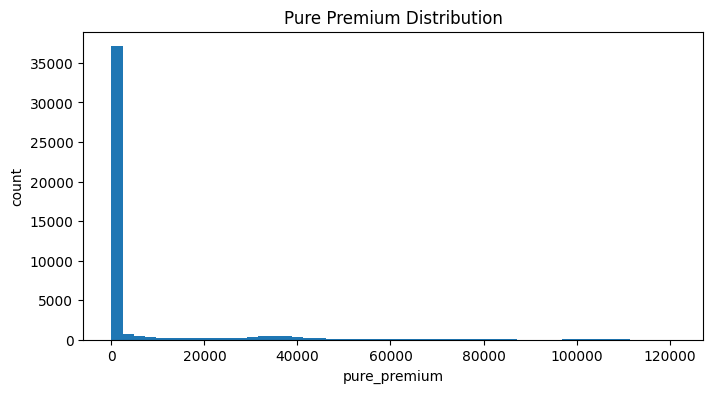

In [59]:
# ===== CELL 3 — PURE PREMIUM =====

import numpy as np
import matplotlib.pyplot as plt
# Đảm bảo severity_hat = 0 nếu không có tổn thất


# Pure premium = frequency × severity
df["pure_premium"] = df["delay_prob"] * df["severity_hat"]

print("=== PURE PREMIUM SUMMARY ===")
print(df["pure_premium"].describe())



plt.figure(figsize=(8,4))
plt.hist(df["pure_premium"], bins=50)
plt.title("Pure Premium Distribution")
plt.xlabel("pure_premium")
plt.ylabel("count")
plt.show()


=== GLOBAL MEANS ===
Global pure premium: 4453.12
Global delay prob:   0.099998
Global severity:     21473.41

✅ Relativities table (all cells):


,Category,Area,rel_freq,rel_sev,rel_pp,n
0,0,0,1.006380e+00,0.738331,7.253532e-01,2042
1,0,1,1.515701e+00,0.819056,1.040757e+00,61
2,0,2,1.926653e-08,0.412942,4.368129e-09,13
3,0,3,1.149504e+00,0.812660,8.622213e-01,599
4,1,0,9.186809e-01,0.704982,6.473599e-01,2077
...,...,...,...,...,...,...
59,14,3,1.162441e+00,0.980752,1.053572e+00,571
60,15,0,1.107844e+00,0.797862,8.685895e-01,2071
61,15,1,1.387098e+00,0.852760,9.908248e-01,82
62,15,2,1.704391e-02,0.545490,1.031541e-02,13


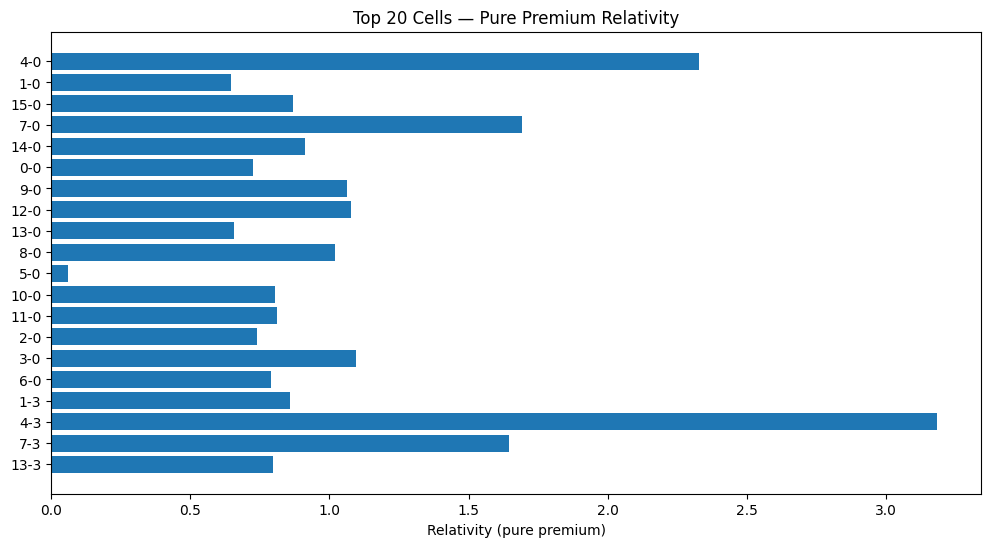

In [60]:
# ===== CELL 4 — RELATIVITIES TABLE TOÀN BỘ (CATEGORY + AREA) =====

import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Chọn chiều phân tích (cell)
cell_dims = ["Category", "Area"]

# 2️⃣ Aggregate: exposure, mean values
agg = df.groupby(cell_dims).agg(
    n=("Order_ID", "count"),
    mean_delay_prob=("delay_prob", "mean"),
    mean_severity=("severity_hat", "mean"),
    mean_pure_premium=("pure_premium", "mean")
).reset_index()

# 3️⃣ Global means
global_mean_pp = df["pure_premium"].mean()
global_mean_delay = df["delay_prob"].mean()
global_mean_sev = df.loc[df["severity_hat"]>0, "severity_hat"].mean()

# 4️⃣ Compute relativities
agg["rel_freq"] = agg["mean_delay_prob"] / global_mean_delay
agg["rel_sev"]  = agg["mean_severity"] / global_mean_sev
agg["rel_pp"]   = agg["mean_pure_premium"] / global_mean_pp

print("=== GLOBAL MEANS ===")
print(f"Global pure premium: {global_mean_pp:.2f}")
print(f"Global delay prob:   {global_mean_delay:.6f}")
print(f"Global severity:     {global_mean_sev:.2f}")

# 5️⃣ Relativities table toàn bộ
relativities_table = agg[cell_dims + ["rel_freq", "rel_sev", "rel_pp", "n"]].copy()
relativities_table.reset_index(drop=True, inplace=True)

print("\n✅ Relativities table (all cells):")
display(relativities_table)

# 6️⃣ Plot top N cells theo exposure (tuỳ chọn)
top_n = 20  # thay đổi N nếu muốn
top_cells = relativities_table.sort_values("n", ascending=False).head(top_n)

plt.figure(figsize=(12,6))
plt.barh(range(len(top_cells)), top_cells["rel_pp"])

# Convert sang string cho labels
labels = top_cells[cell_dims].astype(str).agg('-'.join, axis=1)
plt.yticks(range(len(top_cells)), labels)

plt.title(f"Top {top_n} Cells — Pure Premium Relativity")
plt.xlabel("Relativity (pure premium)")
plt.gca().invert_yaxis()
plt.show()


In [61]:
relativities_table.to_csv('/Users/hoangvupham/Desktop/KLTN_VU/Final Code/Final_relativities.csv')

In [66]:
import pickle

# Lưu mô hình tầng 1 – GLM Binomial
with open("/Users/hoangvupham/Desktop/KLTN_VU/Kafka/binom_model.pkl", "wb") as f:
    pickle.dump(result, f)

# Lưu mô hình tầng 2 – GLM Gamma
with open("/Users/hoangvupham/Desktop/KLTN_VU/Kafka/gamma_model.pkl", "wb") as f:
    pickle.dump(gamma_result, f)

print("✔ Đã lưu 2 file .pkl thành công.")


✔ Đã lưu 2 file .pkl thành công.


In [67]:
import os
os.path.exists("/Users/hoangvupham/Desktop/KLTN_VU/Kafka/binom_model.pkl")
os.path.exists("/Users/hoangvupham/Desktop/KLTN_VU/Kafka/gamma_model.pkl")


True

In [68]:
from joblib import dump

dump(result, "/Users/hoangvupham/Desktop/KLTN_VU/Kafka/binom_model.joblib")
dump(gamma_result, "/Users/hoangvupham/Desktop/KLTN_VU/Kafka/gamma_model.joblib")


['/Users/hoangvupham/Desktop/KLTN_VU/Kafka/gamma_model.joblib']

In [73]:
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ==============================
# 1️⃣ Chuẩn bị dữ liệu
# ==============================
y = df["Delay_Flag"].astype(float)

features = [
    "Agent_Age", "Agent_Rating",
    "Efficiency",
    "Expected_Speed", "Expected_Time_min",
    "Traffic_Weather", "Vehicle_Area",
    "Order_Hour", "Area"
]

X = df[features].copy()

num_cols = ["Agent_Age", "Agent_Rating", "Efficiency", "Expected_Speed", "Expected_Time_min"]
cat_cols = ["Traffic_Weather", "Vehicle_Area", "Order_Hour", "Area"]

# ==============================
# 2️⃣ Tạo encoders + scalers
# ==============================
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le

scalers = {}
for col in num_cols:
    sc = StandardScaler()
    X[[col]] = sc.fit_transform(X[[col]])
    scalers[col] = sc

# ==============================
# 3️⃣ Drop NA nếu có
# ==============================
valid_idx = X.dropna().index
X = X.loc[valid_idx]
y = y.loc[valid_idx]

# ==============================
# 4️⃣ Fit GLM Binomial
# ==============================
X = sm.add_constant(X)
binom_model = sm.GLM(y, X, family=sm.families.Binomial(link=sm.families.links.Logit()))
binom_result = binom_model.fit()

# ==============================
# 5️⃣ Lưu model + encoders + scalers
# ==============================
pickle.dump(binom_result, open("binom_model.pkl", "wb"))
pickle.dump(encoders, open("encoders.pkl", "wb"))
pickle.dump(scalers, open("scalers.pkl", "wb"))

print("✔ Lưu thành công: binom_model.pkl, encoders.pkl, scalers.pkl")


✔ Lưu thành công: binom_model.pkl, encoders.pkl, scalers.pkl


In [74]:
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ==============================
# 1️⃣ Chuẩn bị dữ liệu GLM Gamma (Severity)
# ==============================
df_sev = df[df["Loss_Amount"] > 0].copy()
y_sev = df_sev["Loss_Amount"].astype(float)

features_sev = [
    "Goods_Value",
    "Category",
    "Area",
    "Distance",
    "Vehicle",
    "Weather",
    "Traffic",
    "Agent_Rating"
]

X_sev = df_sev[features_sev].copy()

num_cols_sev = ["Goods_Value", "Distance", "Agent_Rating"]
cat_cols_sev = ["Category", "Area", "Vehicle", "Weather", "Traffic"]

# ==============================
# 2️⃣ Tạo encoders + scalers
# ==============================
encoders_sev = {}
for col in cat_cols_sev:
    le = LabelEncoder()
    X_sev[col] = le.fit_transform(X_sev[col].astype(str))
    encoders_sev[col] = le

scalers_sev = {}
for col in num_cols_sev:
    sc = StandardScaler()
    X_sev[[col]] = sc.fit_transform(X_sev[[col]])
    scalers_sev[col] = sc

# ==============================
# 3️⃣ Drop NA nếu có
# ==============================
valid_idx = X_sev.dropna().index
X_sev = X_sev.loc[valid_idx]
y_sev = y_sev.loc[valid_idx]

# ==============================
# 4️⃣ Fit GLM Gamma
# ==============================
X_sev_const = sm.add_constant(X_sev)
gamma_model = sm.GLM(
    y_sev,
    X_sev_const,
    family=sm.families.Gamma(link=sm.families.links.log())
)
gamma_result = gamma_model.fit()

# ==============================
# 5️⃣ Lưu model + encoders + scalers
# ==============================
pickle.dump(gamma_result, open("gamma_model.pkl", "wb"))
pickle.dump(encoders_sev, open("encoders_sev.pkl", "wb"))
pickle.dump(scalers_sev, open("scalers_sev.pkl", "wb"))

print("✔ Lưu thành công: gamma_model.pkl, encoders_sev.pkl, scalers_sev.pkl")


/Users/hoangvupham/miniconda3/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


✔ Lưu thành công: gamma_model.pkl, encoders_sev.pkl, scalers_sev.pkl


In [76]:
import pickle

# features binomial
features_binom = [
    "Agent_Age", "Agent_Rating",
    "Efficiency",
    "Expected_Speed", "Expected_Time_min",
    "Traffic_Weather", "Vehicle_Area",
    "Order_Hour", "Area"
]
with open("/Users/hoangvupham/Desktop/KLTN_VU/Kafka/binom_features.pkl", "wb") as f:
    pickle.dump(features_binom, f)

# features gamma
features_gamma = [
    "Goods_Value", "Distance", "Agent_Rating",
     "Traffic"
]
with open("/Users/hoangvupham/Desktop/KLTN_VU/Kafka/gamma_features.pkl", "wb") as f:
    pickle.dump(features_gamma, f)
